In [1]:
%matplotlib inline
import pathlib
import sys
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

import tensorflow as tf
from sklearn.model_selection import train_test_split


from livelossplot import PlotLossesKerasTF

os.environ["CUDA_VISIBLE_DEVICES"]="1"

SEED = 199510
np.random.seed(SEED)
tf.random.set_seed(SEED)


ROOT_DIR = pathlib.Path().resolve().parent
DATA_DIR = ROOT_DIR / "Data" / "smear2005"
print(ROOT_DIR)
sys.path.append(str(ROOT_DIR))
from Scripts import utils

C:\Users\marco\Documents\Trabajo\Academia\curso_cisc_2022


In [2]:
# data_dir = pathlib.Path(f"{ROOT_DIR}/dataset/binario/imagenes")

In [3]:
IMG_HEIGHT = 100
IMG_WIDTH = 100
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
BATCH_SIZE = 128
EPOCHS = 50
LEARNING_RATE = 0.001
OPT = tf.keras.optimizers.Nadam(learning_rate=LEARNING_RATE)
LOSS = "binary_crossentropy"
METRICS = ["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")]

In [4]:
# train_ds = tf.keras.utils.image_dataset_from_directory(
#   data_dir,
#   validation_split=0.2,
#   subset="training",
#   seed=SEED,
#   image_size=(IMG_HEIGHT, IMG_WIDTH),
#   batch_size=BATCH_SIZE)

In [5]:
# val_ds = tf.keras.utils.image_dataset_from_directory(
#   data_dir,
#   validation_split=0.2,
#   subset="validation",
#   seed=SEED,
#   image_size=(IMG_HEIGHT, IMG_WIDTH),
#   batch_size=BATCH_SIZE)

In [6]:
dataset = pd.read_csv(f"{DATA_DIR}/dataset.csv")
class_column = "Class_cat_2"

In [7]:
# class_names = train_ds.class_names
# print(class_names)
class_names = dataset[class_column].unique()
print(class_names)

['normal' 'anormal']


In [8]:
num_classes = len(class_names)
print(num_classes)

2


In [9]:
train, test = train_test_split(dataset, test_size=0.2, random_state=SEED, stratify=dataset[class_column])

In [10]:
dataset["filename"].iloc[0]

'C:\\Users\\marco\\Documents\\Trabajo\\Academia\\curso_cisc_2022\\Data\\smear2005\\New database pictures\\normal_superficiel\\153958345-153958392-001.BMP'

In [11]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
)

test_datagen =tf.keras.preprocessing.image.ImageDataGenerator(
)

In [27]:
train_generator = train_datagen.flow_from_dataframe(
                                        train,
                                        None,
                                        x_col='filename',
                                        target_size=(IMG_WIDTH, IMG_HEIGHT),
                                        y_col=class_column,
                                        batch_size=BATCH_SIZE,
                                        seed=SEED,
                                        class_mode='binary'
                                        )


test_generator = test_datagen.flow_from_dataframe(
                                        test,
                                        None,
                                        x_col='filename',
                                        target_size=(IMG_WIDTH, IMG_HEIGHT),
                                        y_col=class_column,
                                        batch_size=BATCH_SIZE,
                                        seed=SEED,
                                        class_mode='binary'
                                        )

Found 733 validated image filenames belonging to 2 classes.
Found 184 validated image filenames belonging to 2 classes.


In [17]:
NEURONS = 1024
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = tf.keras.layers.Rescaling(1./255)(inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(NEURONS, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [18]:
model.compile(optimizer=OPT, loss=LOSS, metrics=METRICS)

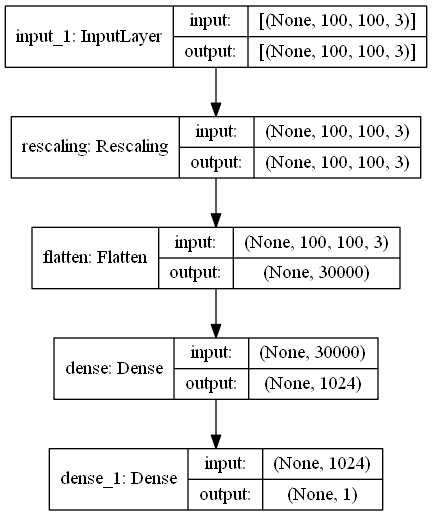

In [19]:
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True, show_layer_names=True)

In [20]:
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 100, 100, 3)       0         
_________________________________________________________________
flatten (Flatten)            (None, 30000)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              30721024  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 30,722,049
Trainable params: 30,722,049
Non-trainable params: 0
_________________________________________________________________
None


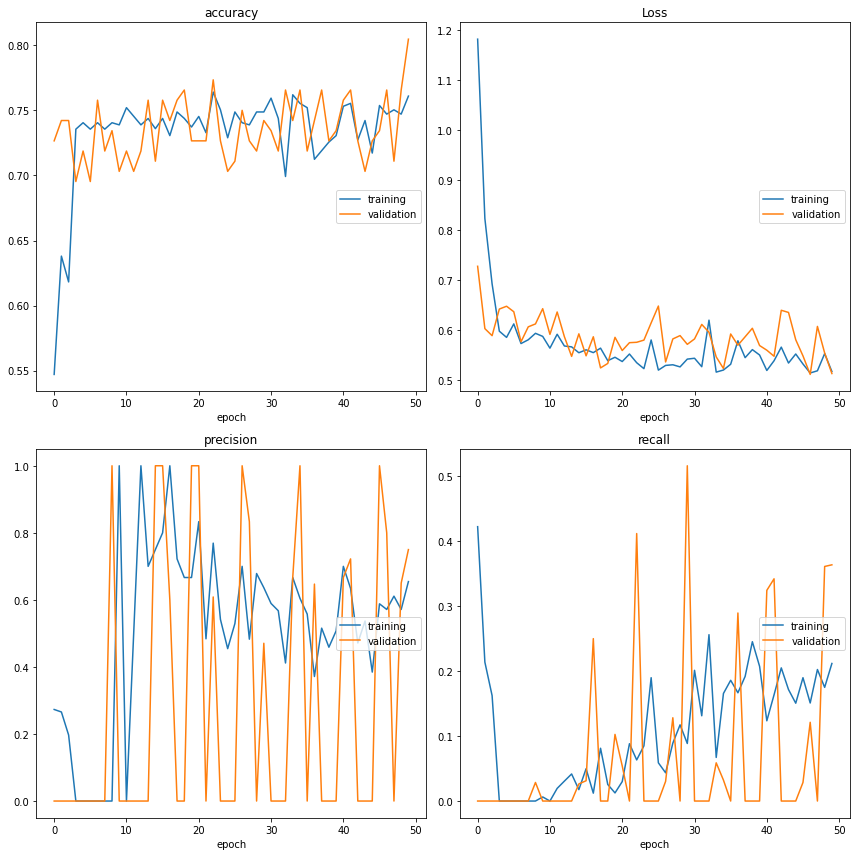

accuracy
	training         	 (min:    0.547, max:    0.764, cur:    0.761)
	validation       	 (min:    0.695, max:    0.805, cur:    0.805)
Loss
	training         	 (min:    0.514, max:    1.182, cur:    0.517)
	validation       	 (min:    0.511, max:    0.727, cur:    0.513)
precision
	training         	 (min:    0.000, max:    1.000, cur:    0.655)
	validation       	 (min:    0.000, max:    1.000, cur:    0.750)
recall
	training         	 (min:    0.000, max:    0.422, cur:    0.212)
	validation       	 (min:    0.000, max:    0.516, cur:    0.364)


In [28]:
history = model.fit(
  train_generator,
  validation_data=test_generator,
  callbacks=[PlotLossesKerasTF()],
  epochs=EPOCHS,
  steps_per_epoch=train_generator.n // train_generator.batch_size,
  validation_steps=test_generator.n // test_generator.batch_size
)

In [ ]:
utils.plot_metrics(history, metrics=['loss', 'accuracy', 'precision', 'recall'] , smooth=True)

In [29]:
evaluations = model.evaluate(test_generator, verbose=0)

for evaluation, metric_name in zip(evaluations, model.metrics_names):
  print(f"{metric_name}: {evaluation}")

loss: 0.5456075668334961
accuracy: 0.7771739363670349
precision: 0.6538461446762085
recall: 0.3469387888908386


In [ ]:
NEURONS = 1024
FILTERS = 32
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = tf.keras.layers.Rescaling(1./255)(inputs)
x = tf.keras.layers.Conv2D(FILTERS, kernel_size=(3, 3), strides=2, padding="same", activation="relu")(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
# x = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=2, padding="same", activation="relu")(x)
# x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(NEURONS, activation="relu")(x)
# x = tf.keras.layers.Dense(128, activation="relu")(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(optimizer=OPT, loss=LOSS, metrics=METRICS)

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True, show_layer_names=True)

In [ ]:
print(model.summary())

In [ ]:
history = model.fit(
  train_generator,
  validation_data=test_generator,
  callbacks=[PlotLossesKerasTF()],
  epochs=EPOCHS,
  steps_per_epoch=train_generator.n // train_generator.batch_size,
  validation_steps=test_generator.n // test_generator.batch_size
)

In [ ]:
utils.plot_metrics(history, metrics=['loss', 'accuracy', 'precision', 'recall'] , smooth=True)

In [ ]:
evaluations = model.evaluate(test_generator, verbose=0)

for evaluation, metric_name in zip(evaluations, model.metrics_names):
  print(f"{metric_name}: {evaluation}")

In [ ]:
base_model = tf.keras.applications.VGG16(weights=None, include_top=False, input_shape=IMG_SHAPE)
preprocess_input = tf.keras.applications.vgg16.preprocess_input
base_model.trainable = True

In [ ]:
NEURONS = 1024
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = preprocess_input(inputs)
x = base_model(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(NEURONS, activation='relu')(x)
# x = tf.keras.layers.Dense(NEURONS, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.compile(optimizer=OPT, loss=LOSS, metrics=METRICS)

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True, show_layer_names=True)

In [ ]:
print(model.summary())

In [ ]:
history = model.fit(
  train_generator,
  validation_data=test_generator,
  callbacks=[PlotLossesKerasTF()],
  epochs=EPOCHS,
  steps_per_epoch=train_generator.n // train_generator.batch_size,
  validation_steps=test_generator.n // test_generator.batch_size
)

In [ ]:
utils.plot_metrics(history, metrics=['loss', 'accuracy', 'precision', 'recall'] , smooth=True)

In [ ]:
evaluations = model.evaluate(test_generator, verbose=0)

for evaluation, metric_name in zip(evaluations, model.metrics_names):
  print(f"{metric_name}: {evaluation}")

In [ ]:
base_model = tf.keras.applications.ResNet50(weights=None, include_top=False, input_shape=IMG_SHAPE)
preprocess_input = tf.keras.applications.resnet50.preprocess_input
base_model.trainable = True

In [ ]:
NEURONS = 1024
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = preprocess_input(inputs)
x = base_model(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(NEURONS, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.compile(optimizer=OPT, loss=LOSS, metrics=METRICS)

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True, show_layer_names=True)

In [ ]:
print(model.summary())

In [ ]:
history = model.fit(
  train_generator,
  validation_data=test_generator,
  callbacks=[PlotLossesKerasTF()],
  epochs=EPOCHS,
  steps_per_epoch=train_generator.n // train_generator.batch_size,
  validation_steps=test_generator.n // test_generator.batch_size
)

In [ ]:
utils.plot_metrics(history, metrics=['loss', 'accuracy', 'precision', 'recall'] , smooth=True)

In [ ]:
evaluations = model.evaluate(test_generator, verbose=0)

for evaluation, metric_name in zip(evaluations, model.metrics_names):
  print(f"{metric_name}: {evaluation}")